# 0.0 - Imports

In [1]:
import math
import inflection
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.core.display import HTML
from IPython.core.display import Image
import datetime

## 0.1 - Helper Functions

In [2]:
display(HTML("<style>.container { width:100% !important; }</style>"))

## 0.2 - Loading data

In [3]:
df_sales_raw = pd.read_csv('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\data\\train.csv', low_memory=False)
df_store_raw = pd.read_csv('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto\\data\\store.csv', low_memory=False)

In [4]:
#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 - Descrição dos dados

In [5]:
#copiar o dataframe pra manter sempre um registro de cada etapa separado do resultado da etapa anterior
df1 = df_raw.copy()

## 1.1 - Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

df1.columns = cols_new

## 1.2 - Data Dimensions

In [7]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 1017209
Number of Cols: 18


## 1.3 - Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Fillout NA

In [10]:
#competition_distance 
#-> Assumption: se o o maior valor da coluna é 70mil. 200mil seria o mesmo q dizer que a competição é o mínimo possível
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
#-> Assumption: Como não da pra saber se está NA pq:
               #  1 - Não existe competidor
               #  2 - O competidor abriu antes da loja
#Assim é melhor colocar a data da venda mais recente
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
#-> Assumption: Mesma lógica da de cima
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
#-> Assumption: Se está é NA é pq a lojo não participou da promoção
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
#-> Assumption: O mesmo da de cima
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
#-> Assumption: 
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if  x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

## 1.6 - Change Types

In [11]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7 - Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 - Numeric Attributes

In [13]:
#central tendency - média e mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std) ).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'media', 'mediana', 'std', 'skew', 'kurtosis']

In [14]:
m

,attributes,min,max,range,media,mediana,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\galves\AppData\Local\Temp\ipykernel_10308\3919186694.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1['sales']) #a distplot vai ser retirada do seaborn


<AxesSubplot:xlabel='sales', ylabel='Density'>

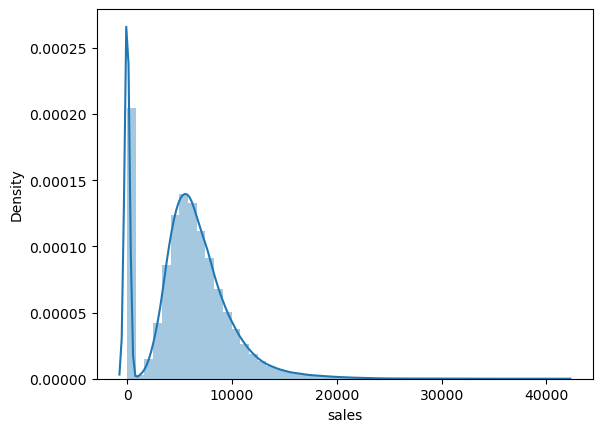

In [15]:
sns.distplot(df1['sales']) #a distplot vai ser retirada do seaborn
#sns.displot(df1['sales'])
#sns.histplot(df1['sales'])

### 1.7.2 - Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

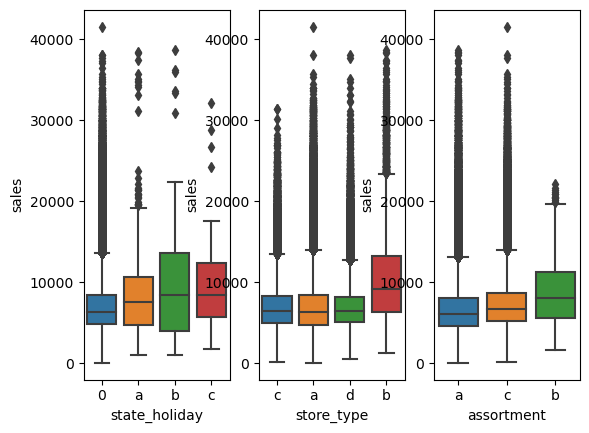

In [17]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# os pontilhados acima são os outliers (calculados automaticamente sendo acima de 3 vezes o desvio padrão)
# o traço no meio do retangulo colorido é o 50º quartil, é a mediana. Anterior tem o 25º quartil e depois tem o 75ºquartil

## 1.8 - 

In [18]:
df1[(df1['state_holiday'] != 0)]

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9,2008,0,31,2015,0,Jul,0
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9,2009,0,31,2015,0,Jul,0
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4,2015,0,31,2015,0,Jul,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6,2014,1,31,2013,"Jan,Apr,Jul,Oct",Jan,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4,2006,0,1,2013,0,Jan,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,1,2013,0,1,2013,0,Jan,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,1,2013,0,1,2013,0,Jan,0


# 2.0 - Feature Engineering

In [19]:
df2 = df1.copy()

## 2.1 - Mapa mental de Hipóteses

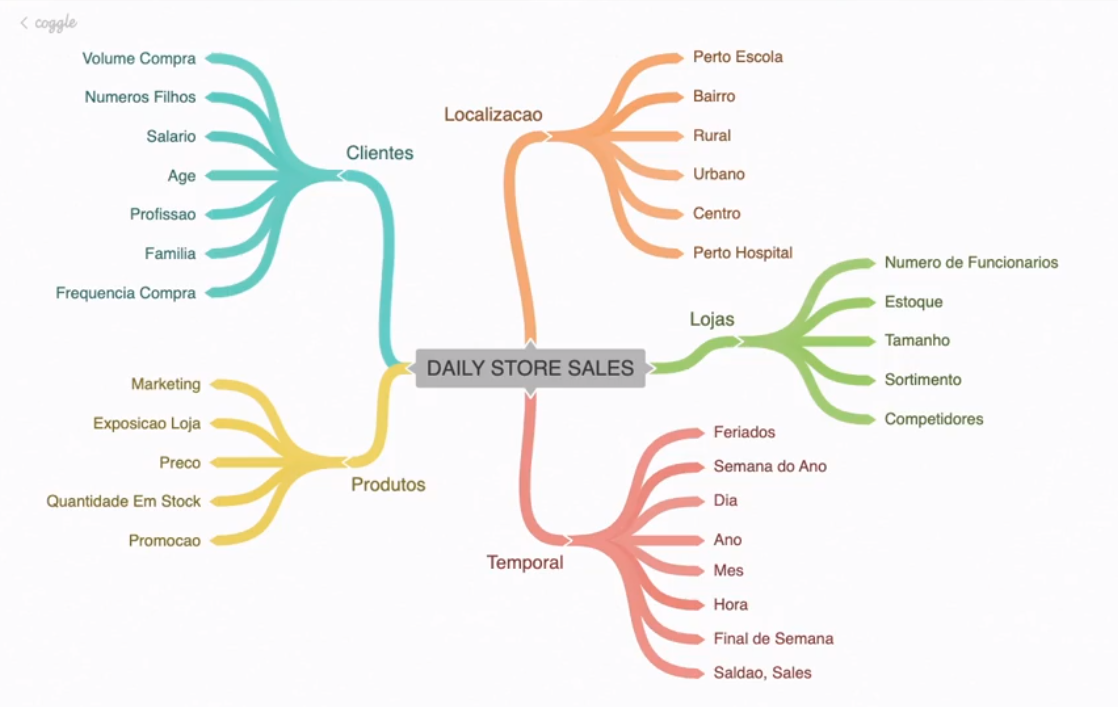

In [20]:
Image('C:\\Users\\galves\\Documents\\Gabriel\\Ciência de dados\\Cursos\\Data Science em Produção\\projeto//img//mind_map_hypothesis.png')

## 2.2 - Criação das Hipóteses

### 2.2.1 - Hipóteses loja

**1.** Lojas com um **maior quadro de funcionários** deveriam **vender mais**

**2.** Lojas com **maior estoque** deveriam **vender mais**

**3.** Lojas com **maior porte** deveriam **vender mais**

**4.** Lojas com **menor porte** deveriam **vender menos**

**5.** Lojas com **maior sortiment**o deveriam **vender mais**

**6.** Lojas com **competidores mais próximos** deveriam **vender menos**

**7.** Lojas com **competidores à mais tempo** deveriam **vender mais**

### 2.2.2 - Hipóteses produto

**1.** Lojas investem mais em **marketing** deveriam **vender mais**

**2.** Lojas com maior **exposição de produtos** deveriam **vender mais**

**3.** Lojas que tem **preços menores** nos produtos deveriam **vender mais**

**4.** Lojas que tem **promoções mais agressivas** (descontos maiores) deveriam **vender mais**

**5.** Lojas que tem **promoções ativas por mais tempo** deveriam **vender mais**

**6.** Lojas que ficam **mais dias com promoção** deveriam **vender mais**

**7.** Lojas com mais **promoções consecutivas** deveriam **vender mais**

### 2.2.3 - Hipóteses Tempo

**1.** Lojas que **ficam abertas durante feriado de Natal** deveriam **vender mais**

**2.** Lojas deveriam **vender mais** ao **longo dos anos**

**4.** Lojas deveriam **vender mais** no **segundo semestre** do ano

**5.** Lojas deveriam **vender mais** **depois do dia 10** de cada mês

**6.** Lojas deveriam **vender menos** aos **finais de semana**

**7.** Lojas deveriam **vender menos** durante os **feriados escolares**





### 2.3 - Lista Final de Hipóteses 

**1.** Lojas com **maior sortimento** deveriam **vender mais**

**2.** Lojas com **competidores mais próximos** deveriam **vender menos**

**3.** Lojas com **competidores à mais tempo** deveriam **vender mais**

**4.** Lojas que tem **promoções ativas por mais tempo** deveriam **vender mais**

**5.** Lojas que ficam **mais dias com promoção** deveriam **vender mais**

**6.** Lojas com mais **promoções consecutivas** deveriam **vender mais**

**7.** Lojas que **ficam abertas durante feriado de Natal** deveriam **vender mais**

**8.** Lojas deveriam **vender mais** ao **longo dos anos**

**9.** Lojas deveriam **vender mais** no **segundo semestre** do ano

**10.** Lojas deveriam **vender mais** **depois do dia 10** de cada mês

**11.** Lojas deveriam **vender menos** aos **finais de semana**

**12.** Lojas deveriam **vender menos** durante os **feriados escolares**

## 2.4 - Feature Engineering

In [21]:
df2['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1),axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [23]:
df2['state_holiday']

0             regular_day
1             regular_day
2             regular_day
3             regular_day
4             regular_day
                ...      
1017204    public_holiday
1017205    public_holiday
1017206    public_holiday
1017207    public_holiday
1017208    public_holiday
Name: state_holiday, Length: 1017209, dtype: object

# 3.0 - Filtragem de variáveis

In [24]:
df3 = df2.copy()

## 3.1 - Filtragem das linhas

In [25]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 - Seleção das colunas

In [26]:
#a coluna customers deve ser retirada pq como não vai ser possível ter os dados no momento da predição (seria necessário fazer uma previsão que gastaria muito tempo e não é necessário para essa etapa do processo)
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [27]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 - Análise Exploratória dos dados

In [28]:
df4 = df3.copy()

## 4.1 - Análise Univariada

### 4.1.1 - Response variable

C:\Users\galves\AppData\Local\Temp\ipykernel_10308\1570643180.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((df4['sales'])) #se alterar para sns.distplot((df4['sales'], kde=False)) mostra o histograma


<AxesSubplot:xlabel='sales', ylabel='Density'>

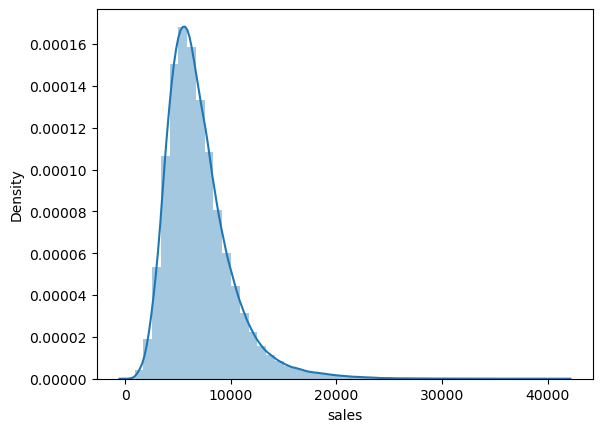

In [29]:
sns.distplot((df4['sales'])) #se alterar para sns.distplot((df4['sales'], kde=False)) mostra o histograma

#sns.distplot(np.log1p(df4['sales'])) multplica todos os valores pelo log

### 4.1.2 - Numeriacal variable

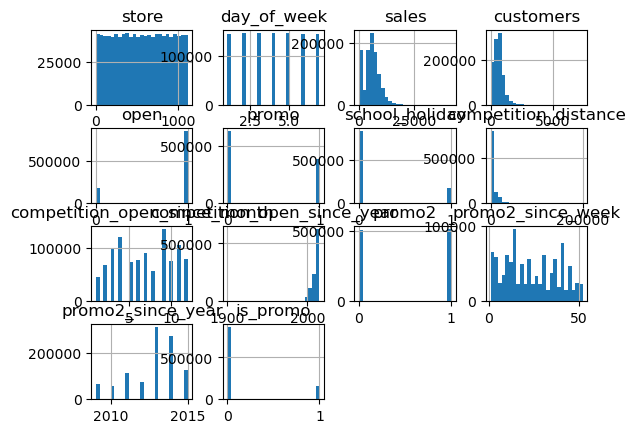

In [30]:
num_attributes.hist(bins=25);
plt.rcParams['figure.figsize'] = [15, 15] #[largura, altura]
plt.rcParams['figure.dpi'] = 200

### 4.1.3 - Categorical variable

In [31]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

KeyError: 0

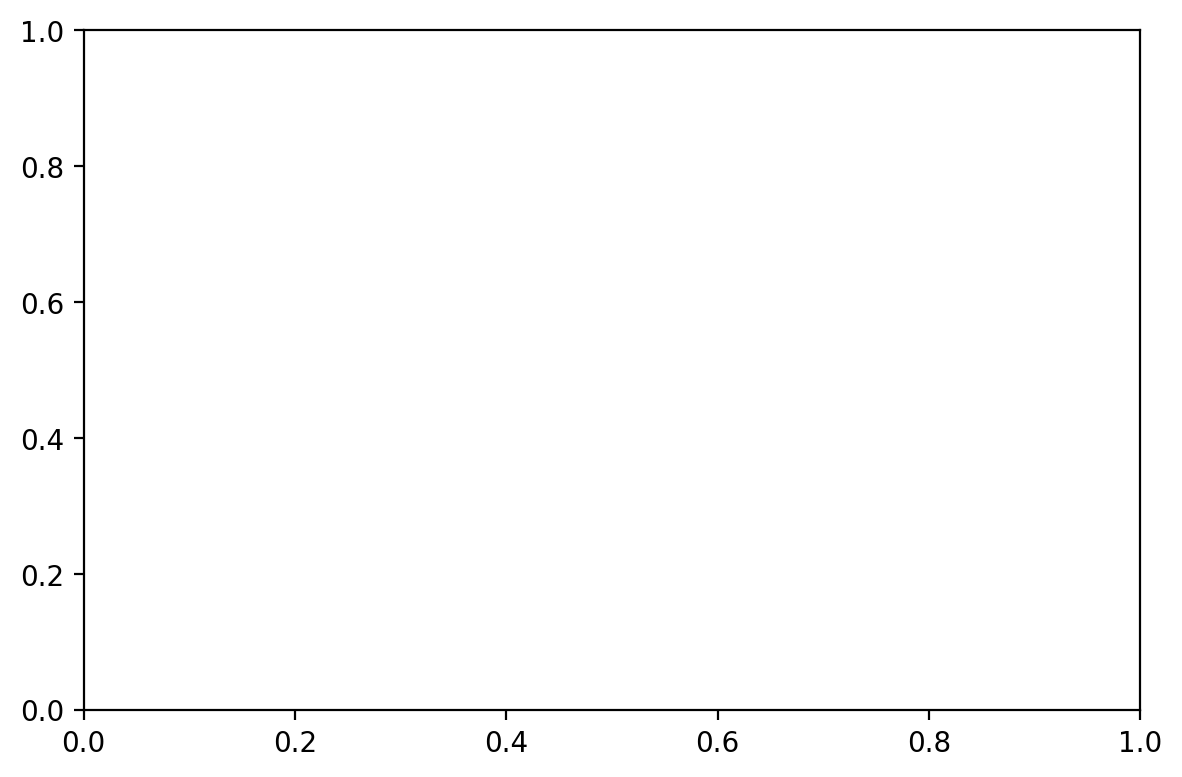

In [32]:
#state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade=True)

#store_type
plt.subplot(3, 2, 3)
sns.countplot(df4['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade=True)


#assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade=True)

## 4.2 - Análise Bivariada

### H1 - Lojas com maior sortimento deveriam vender mais
**FALSA** - Lojas com MAIOR SORTMENTO vendem MENOS

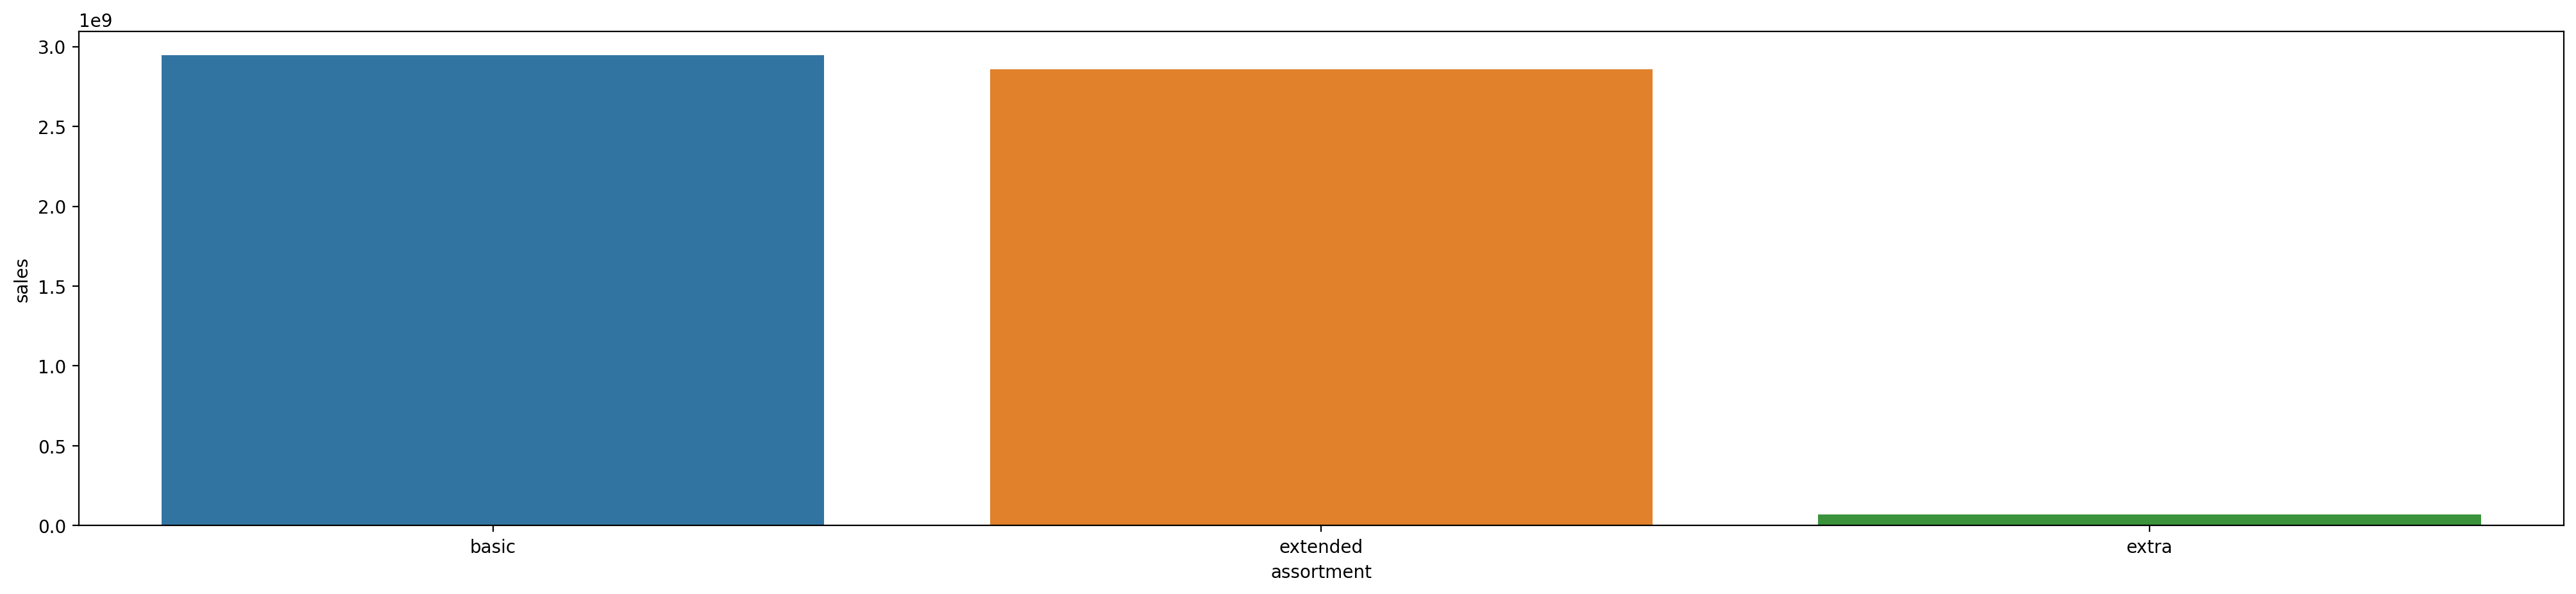

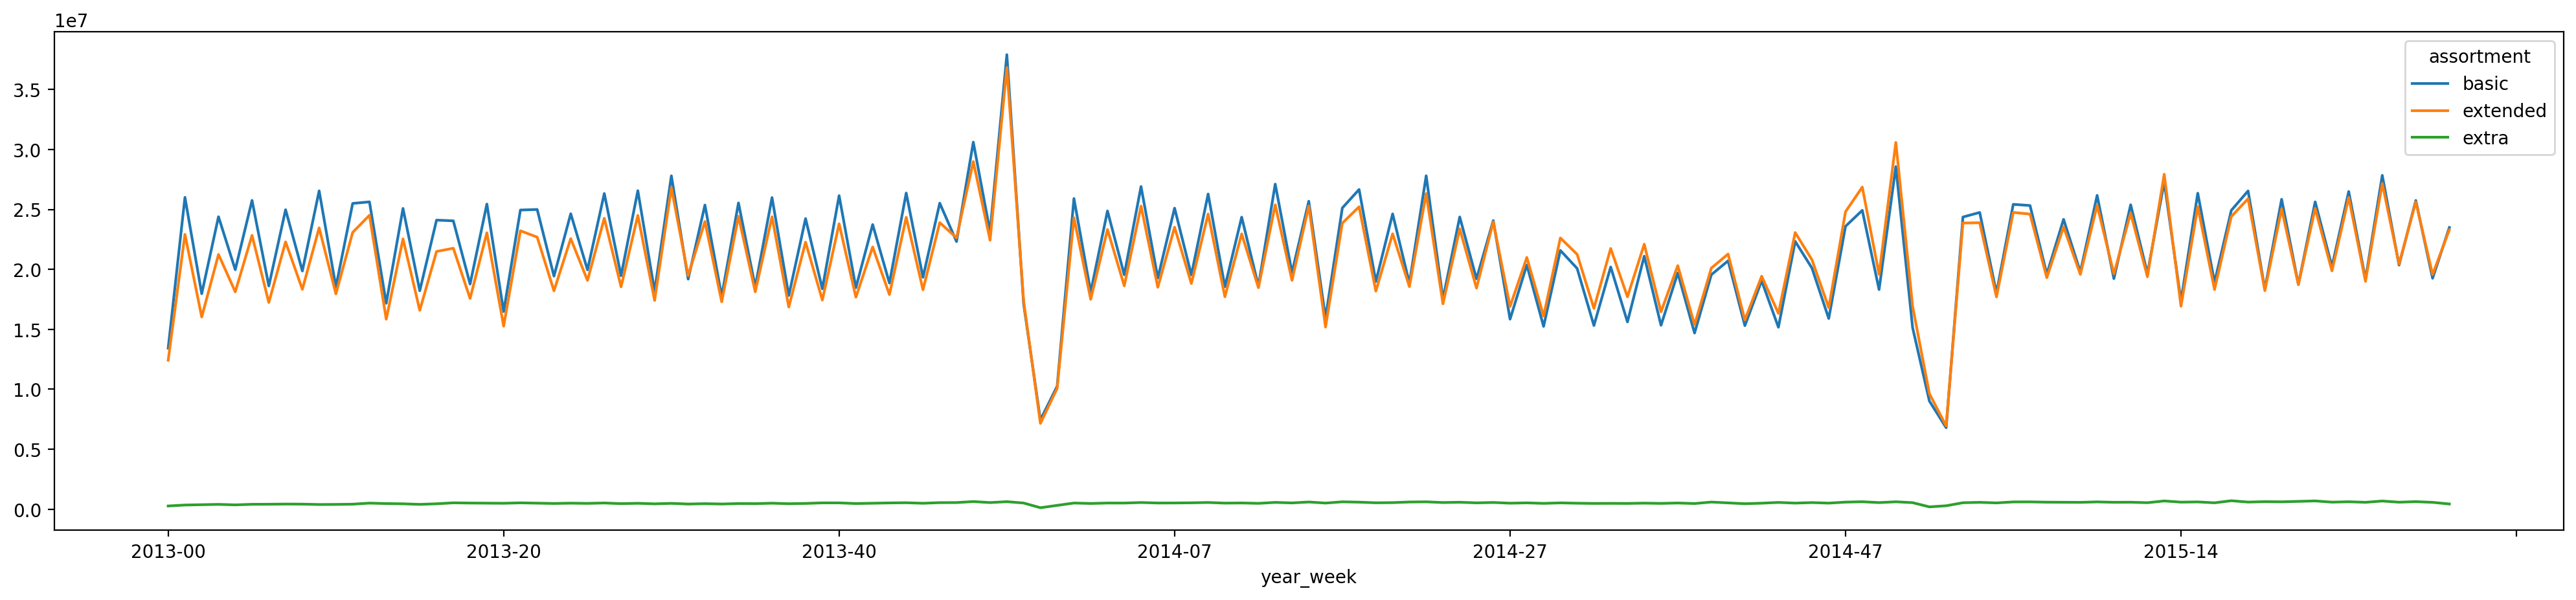

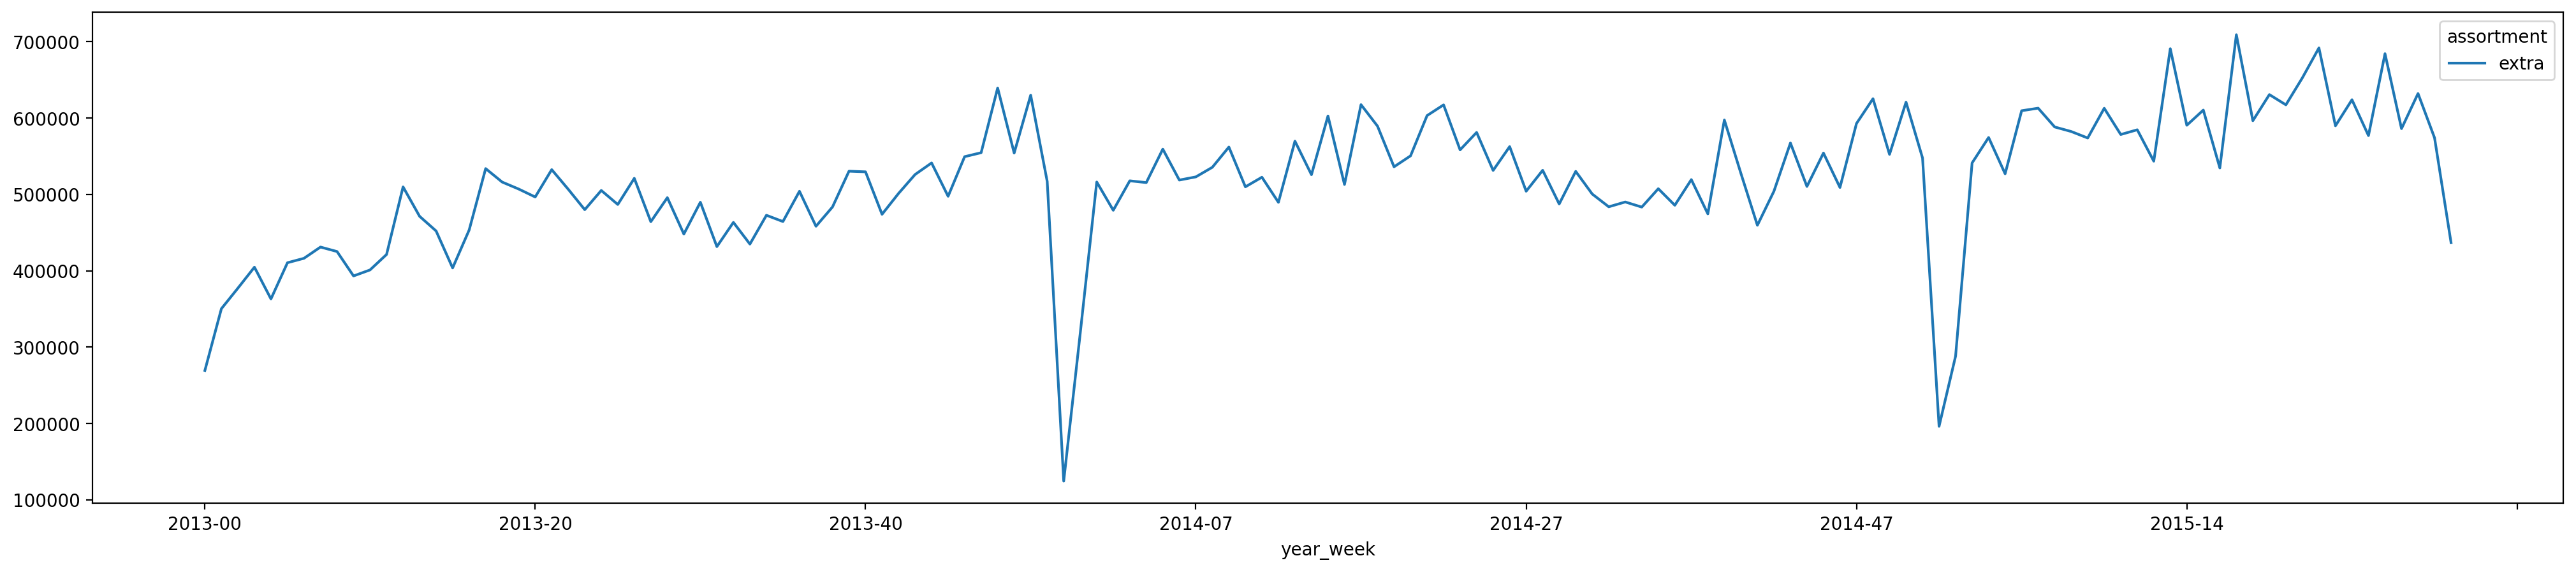

In [51]:
plt.rcParams['figure.figsize'] = [25, 5]
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1);

#Para observar a variação durante as semanas dos anos para cada um dos assortments
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

#Para observar melhor a linha do extra, já que ela estava muito reta antes
aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2 - Lojas com competidores mais próximos deveriam vender menos
**FALSA** - Lojas com competidores mais próximos vendem mais

C:\Users\galves\AppData\Local\Temp\ipykernel_10308\1160584224.py:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aux1.corr(method='pearson'), annot=True);


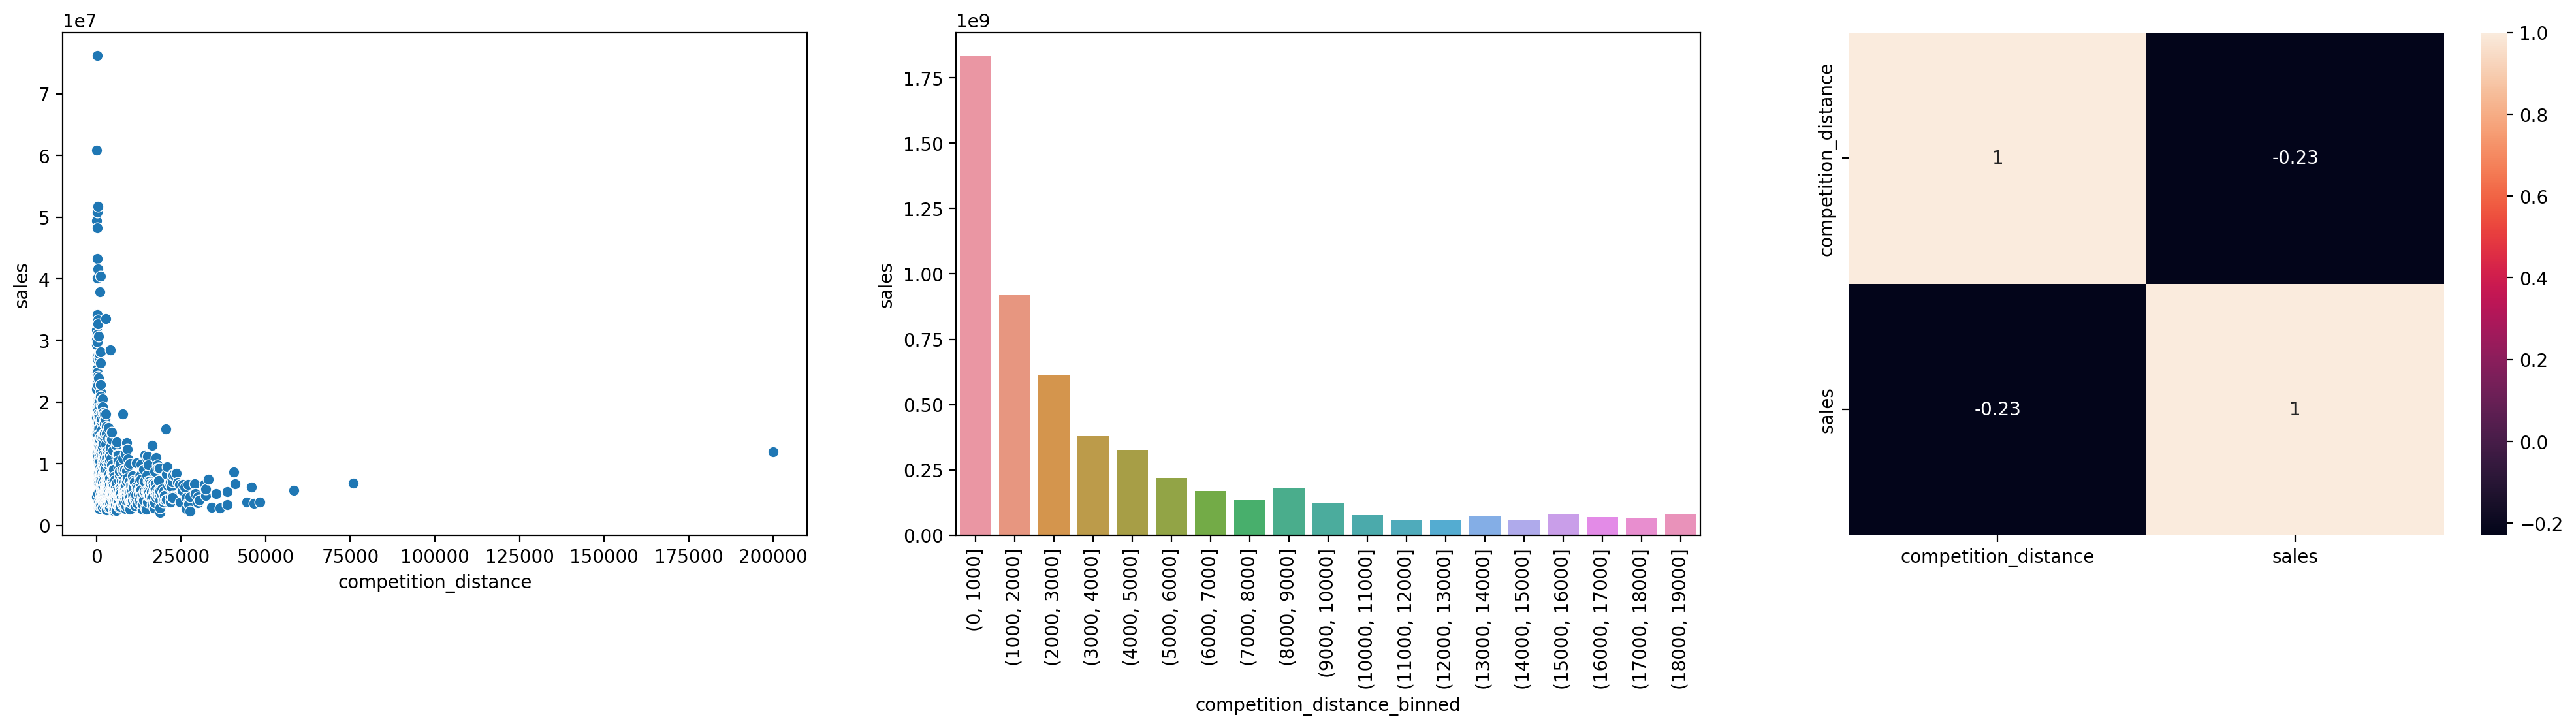

In [61]:
plt.rcParams['figure.figsize'] = [25, 5]
#Como da forma abaixo o gráfico fica muito granular é melhor separar a distancia em grupos, usando o bin
#aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
#sns.barplot(x='competition_distance', y='sales', data=aux1);

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
plt.xticks(rotation=90)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3 - Lojas com competidores à mais tempo deveriam vender mais
**FALSA** - Lojas com competidores à mais tempo vendem menos

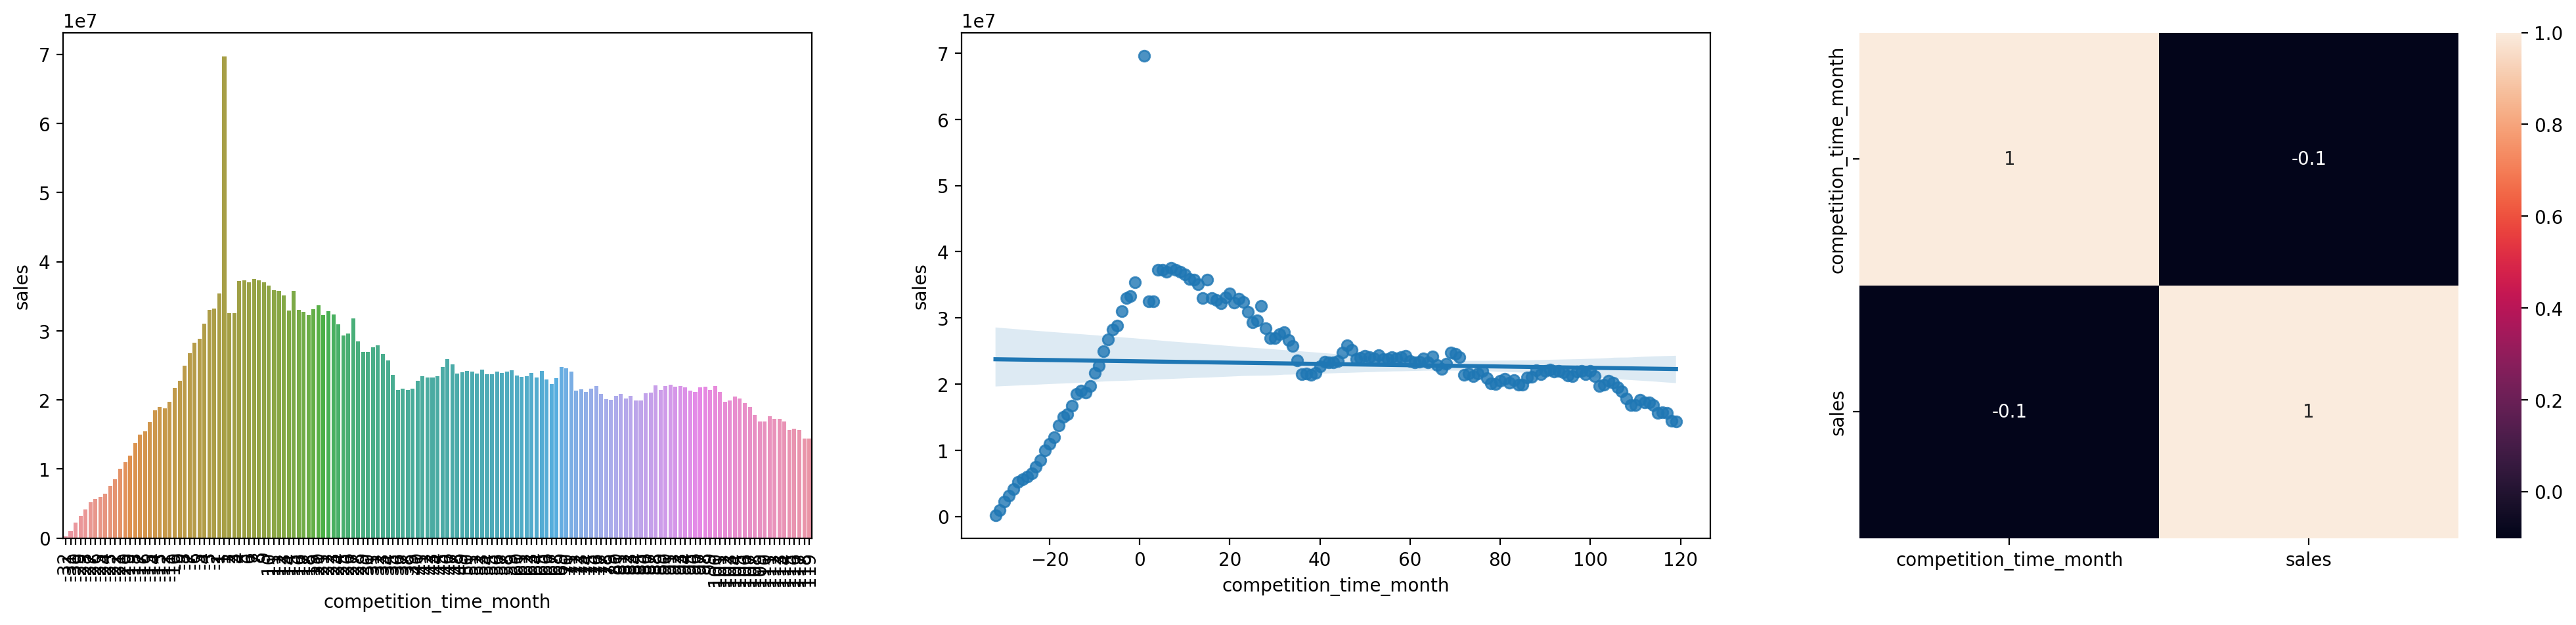

In [71]:
#competition_time_month representa a diferença entre a data observada com o dia q o competidor abriu (a distância entre uma data e a data de abertura do competidor)

plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


## 4.3 - Análise Multivariada